## 3) First Machine Learning Model

**The table of contents**:
<br> 3.10 - K-NN
<br> 3.11 - Save Results

### 3.1. Import Libraries

In [1]:
# Import librairies
import os
import pandas as pd
import numpy as np

#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint

In [2]:
# Import the necessary librairires for model fitting.

from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#


import warnings
from scipy.linalg import LinAlgWarning

In [3]:
# Take seaborn as preference graphic interface
sns.set()

In [4]:
# Load Main data & Save Models in the following folders
path_main_save = '/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/'
path_secondary_save = 'US_Pesticide/2015PDPDatabase/SaveModels/'

path_save = os.path.join(path_main_save,path_secondary_save)
os.chdir(path_save)
os.getcwd()

'/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/US_Pesticide/2015PDPDatabase/SaveModels'

### 3.2 General Functions for ML Models

In [5]:
def sortout_data(parameter, grid, grid_search, log=False):

    #Prepare the dataframe based on cv_results._keys()
    
    items_col = ['mean_test_neg_mean_squared_error','std_test_neg_mean_squared_error',
                 'mean_train_neg_mean_squared_error','std_train_neg_mean_squared_error',
                'mean_test_r2', 'std_test_r2','mean_train_r2','std_train_r2']

    cols = []

    for item in items_col:
        if item not in cols:
            cols.append(item)
    
    # Incorporate the paramaters from the grid to the cv_results dataframe
    
    col_grid = list(grid.keys()) 
    col_grid = ['param_' + c for c in col_grid] # Add 'param_'
    col_grid = sorted(col_grid)
    cols.extend(col_grid) 
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.loc[:, cols]
    cv_results = cv_results.loc[:,::-1] # Reverse the columns
    cv_results.columns = cv_results.columns.str.replace('neg_mean_squared_error','MSE')#rename the columns
    
    # Grid/RandomizeSearch displays negative values due to maximize per definition, when minimize negative values
    cv_results[['mean_train_MSE','mean_test_MSE']] = cv_results[['mean_train_MSE','mean_test_MSE']].abs() #negative value into positive values
    
    for item in cv_results.columns: #Extract the columns name for the parameter
        if ('param' in item):
             # For example from param_Ridge__alpha: alpha; from Ridge__alpha:alpha check alpha=alpha
                if (item.split('__')[1] == parameter.split('__')[1]): 
                    item_param = item
        
    grouped = cv_results.groupby(item_param) # Sort out the data based on parameters

     # Train data -R2/MSE
    mean_train_r2 = grouped.mean_train_r2.mean()
    std_train_r2 = grouped.std_train_r2.mean()
    mean_train_MSE = grouped.mean_train_MSE.mean()
    std_train_MSE = grouped.std_train_MSE.mean()

    #Test data -R2/MSE
    mean_test_r2 = grouped.mean_test_r2.mean()
    std_test_r2 = grouped.std_test_r2.mean()
    mean_test_MSE = grouped.mean_test_MSE.mean()
    std_test_MSE = grouped.std_test_MSE.mean()
    
    param = mean_test_r2.index.values # Gather the parameters for plotting
    best_param= mean_test_r2.idxmax() # Extract the best_parameter for plotting

    best_output = grouped.get_group(best_param) # Take the best values from the dataset based on best param
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    # Plot R2/MSE vs parameter
    if log==True:
        # Logarithmn scale
        ax[0].semilogx(param, mean_train_r2, color='blue', alpha=0.5, label='Train')
        ax[0].semilogx(param, mean_test_r2, color='orange', alpha=0.5, label='Validation')
        x_axis = 'log({})'.format(parameter)
       
        ax[1].semilogx(param, mean_train_MSE, color='blue', alpha=0.5, label='Train')
        ax[1].semilogx(param, mean_test_MSE, color='orange', alpha=0.5, label='Validation')
        
    
    else: # Not a logarithmn scale
        ax[0].plot(param, mean_train_r2, alpha=.5, color='blue', label='Train')
        ax[0].plot(param, mean_test_r2, alpha=.5, color='red', label='Validation')
        x_axis = '{}'.format(parameter)
        
        ax[1].plot(param, mean_train_MSE, alpha=.5, color='blue', label='Train')
        ax[1].plot(param, mean_test_MSE, alpha=.5, color='red', label='Validation')
    

    
    # Plot R2
    ax[0].fill_between(param, mean_train_r2 - std_train_r2,  mean_train_r2 + std_train_r2, alpha=0.5)
    ax[0].fill_between(param, mean_test_r2 - std_test_r2,  mean_test_r2 + std_test_r2, alpha=0.5)
    ax[0].scatter(best_param, mean_test_r2.max(), marker='x', color='red', zorder=10, label='Max_Validation')
    ax[0].legend()
    ax[0].set_xlabel(x_axis)
    ax[0].set_ylabel('$R^2$')
    ax[0].set_title('best valid accuracy with {}={:.0f} \n gives  test_r2 = {:.3f} ± {:.3f} - mean/std'.
                  format(parameter,
                         grid_search.best_params_[parameter], 
                         mean_test_r2[best_param],
                         std_test_r2[best_param]))

    
    # Plot MSE
    ax[1].fill_between(param, mean_train_MSE - std_train_MSE,  mean_train_MSE + std_train_MSE, alpha=0.5)
    ax[1].fill_between(param, mean_test_MSE- std_test_MSE,  mean_test_MSE + std_test_MSE, alpha=0.5)
    ax[1].scatter(best_param, mean_test_MSE.min(), marker='x', color='red', zorder=10, label='Max_Validation')
    ax[1].legend()
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('$MSE$')
    ax[1].set_title('best MSE with {}={:.0f} \n gives  test_MSE = {:.3f} ± {:.3f} - mean/std'.
                  format(parameter,
                         grid_search.best_params_[parameter],
                         mean_test_MSE[best_param],
                         std_test_MSE[best_param]))


    plt.subplots_adjust(wspace=0.2, hspace=0.2) 
    plt.show()
    
    best_output.columns = cv_results.columns.str.replace('test','validation')#rename the columns
    best_output['Model'] = parameter.split('__')[0] #Retrieve the name of the model
    

    return best_output

In [6]:
def sortout_params(grid, grid_search):
    
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('-'*50)
    print('Best estimators: {}'. format(grid_search.best_estimator_))
    print('-'*50)
    print('Best score: {}'. format(grid_search.best_score_))
    print('-'*50)
    params = sorted(list(grid.keys())) #List the parameters from the grid for feeding the parameter from sortout_data function
    
    return params

### 3.3 Load the data 

In [7]:
# Load the data
#with np.load('data_pesticides_binarycoding.npz', allow_pickle=True) as npz_data:
with np.load('data_pesticides_option3_EDA_1.npz', allow_pickle=True) as npz_data:
    print(list(npz_data.keys()))
    df = dict(npz_data.items())
    
# option 1: Sample data: 38751 column 'concen' and take only non zeros values ()
# option 2: All the data 2M (100% of the dataset, 98.5% 0-values, 1.5% non-zeros values)
# option 3: Sample data: around 100'000 - 5% of the dataset (mix zeros and non zeros in same ratio than option2 )

['data', 'target', 'labels']


In [8]:
# Define X and y values
X = df['data']
y = df['target']
labels = df['labels']

### 3.4 Cost Functions

In [9]:
def MSE(y,y_pred):
    return np.mean(np.square(y-y_pred))

In [10]:
# Define Mean Absokute Error 
def MAE (y,y_pred):
    return np.mean(np.absolute(y-y_pred))

In [11]:
def RSS (y,y_pred):
    return np.sum(np.square(y-y_pred))

In [12]:
def R2 (y,y_pred):
    return r2_score(y,y_pred)

> **Remarks**:
<br> - The chosen cost function is MSE: Mean Square Error as being a metrics given enough statistical information
<br> - Beside MSE; R2 will also be computed but as information only

### 3.5 Split Train/Test Data

In [13]:
# Convert X as float 
X = X.astype(float)

In [14]:
# Split the data train/test for the simple model 70/30% train/test
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.3, random_state=0)

In [15]:
# Check out the dimension of the 

print('-'*80)
print('Dimension of the train data: X_tr={}; y_tr={}'.format(X_tr.shape, y_tr.shape))
print('Dimension of the test data: X_te={}; y_te={}'.format(X_te.shape, y_te.shape))
print('-'*80)
print('Data type for the train data: X_tr={}; y_tr={}'.format(X_tr.dtype, y_tr.dtype))
print('Data type for the test data: X_te={}; y_te={}'.format(X_te.dtype, y_te.dtype))
print('-'*80)

--------------------------------------------------------------------------------
Dimension of the train data: X_tr=(81431, 85); y_tr=(81431,)
Dimension of the test data: X_te=(34899, 85); y_te=(34899,)
--------------------------------------------------------------------------------
Data type for the train data: X_tr=float64; y_tr=float64
Data type for the test data: X_te=float64; y_te=float64
--------------------------------------------------------------------------------


In [16]:
# The rumber of 0s and non-0s values express in % per column of the train dataset

y_tr_0s_vals = np.count_nonzero(y_tr==0)
y_tr_no0s_vals = np.count_nonzero(y_tr!=0)

print('Number of 0s value in train data: {} and in percent of the dataset {:.2f}%'. 
      format(y_tr_0s_vals, 100*y_tr_0s_vals/len(y_tr)))
print('Number of non-0s value in train data: {} and in percent of the dataset {:.2f}%'. 
      format(y_tr_no0s_vals, 100*y_tr_no0s_vals/len(y_tr)))


Number of 0s value in train data: 80097 and in percent of the dataset 98.36%
Number of non-0s value in train data: 1334 and in percent of the dataset 1.64%


In [17]:
# The rumber of 0s and non-0s values express in % per column of the test dataset

y_te_0s_vals = np.count_nonzero(y_te==0)
y_te_no0s_vals = np.count_nonzero(y_te!=0)

print('Number of 0s value in test data: {} and in percent of the dataset {:.2f}%'. 
      format(y_te_0s_vals, 100*y_te_0s_vals/len(y_te)))
print('Number of non-0s value in test data: {} and in percent of the dataset {:.2f}%'. 
      format(y_te_no0s_vals, 100*y_te_no0s_vals/len(y_te)))

Number of 0s value in test data: 34310 and in percent of the dataset 98.31%
Number of non-0s value in test data: 589 and in percent of the dataset 1.69%


### 3.7 Data Preparation

In [18]:
# Scale the data between 0 and 1 for the pipeline models
scale = StandardScaler()

In [19]:
# Use RandomState for reproducibility / not necessary could be random_state=1 for example, needs a value for reproducibility
random_state = np.random.RandomState(42)

### 3.10 K-NN

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
#Create a pipeline
pipe_knn = Pipeline([
    ('scaler', scale), 
    ('knn', KNeighborsRegressor(algorithm='brute')) 
])

# Create a grid search
k_values = np.arange(1,121,20)

grid_knn = {
    'knn__n_neighbors': k_values,
    'knn__weights':['uniform','distance'],
    'knn__p':[1,2]
}

In [30]:
# Use GridSearchCV for optimization

random_search_knn = RandomizedSearchCV(pipe_knn, grid_knn, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
                                    random_state=random_state, return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # Sort out r2 and MSE



#grid_search_knn = GridSearchCV(pipe_knn, grid_knn, cv=3, verbose=10, n_jobs=-1, refit='r2',  #Maximize r2
#                                 return_train_score=True, scoring=['neg_mean_squared_error', 'r2']) # optimize r2 and MSE

#tuned_search_knn  = TuneSearchCV(pipe_knn, grid_knn, early_stopping=True, scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1,
#                                  refit='r2', cv=5, verbose=2, return_train_score=True, max_iters=3, search_optimization='random')
                                 
result_knn_grid = random_search_knn.fit(X_tr, y_tr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tos

In [31]:
# Sortout the best parameters
params_knn = sortout_params(grid_knn, random_search_knn)
params_knn

Best parameters: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 41}
--------------------------------------------------
Best estimators: Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=41, p=1,
          weights='uniform'))])
--------------------------------------------------
Best score: 0.025721274016834585
--------------------------------------------------


['knn__n_neighbors', 'knn__p', 'knn__weights']

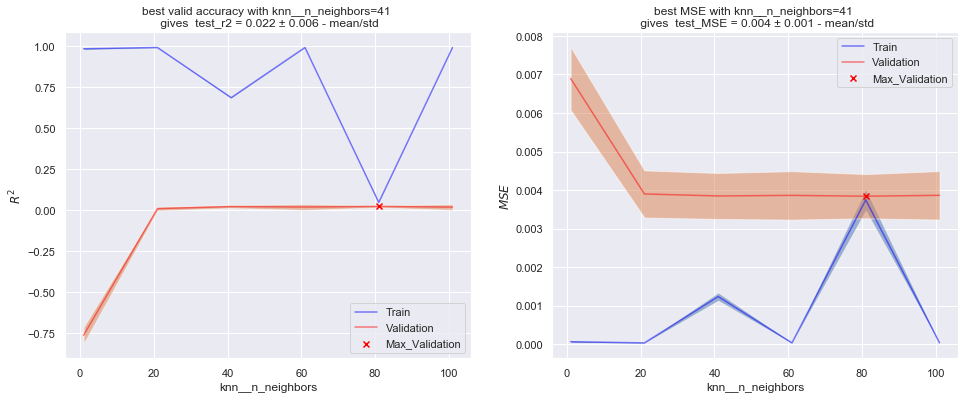

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,param_knn__weights,param_knn__p,param_knn__n_neighbors,std_train_r2,mean_train_r2,std_validation_r2,mean_validation_r2,std_train_MSE,mean_train_MSE,std_validation_MSE,mean_validation_MSE,Model
1,uniform,1,81,0.004243,0.045412,0.006127,0.021918,0.000284,0.003748,0.000585,0.003843,knn
3,uniform,2,81,0.003948,0.046904,0.005851,0.022592,0.000269,0.003741,0.000562,0.003837,knn


In [40]:
result_knn = sortout_data(params_knn[0], grid_knn, random_search_knn, log=False)
result_knn

In [33]:
# Apply the results of the grid search to the test data
knn_test_score = random_search_knn.score(X_te, y_te)
knn_test_score

0.03135167913201775

In [34]:
# Apply the results of the optimized grid search to the test data
#R2
knn_test_score = random_search_knn.score(X_te, y_te)
print('The test_r2 for rf based on best parameter from grid search: {:.4f}'.format(knn_test_score))

#MSE
y_pred_knn= result_knn_grid.predict(X_te)
print('The test_MSE for rf  based on best parameter from grid search: {:.6f}'.format(MSE(y_pred_knn,y_te)))

The test_r2 for rf based on best parameter from grid search: 0.0314
The test_MSE for rf  based on best parameter from grid search: 0.006411


In [35]:
results_knn_test = pd.DataFrame({'Model':'knn',
                                   'mean_test_r2':[knn_test_score],
                                   'mean_test_MSE':[MSE(y_pred_knn,y_te)]})
results_knn_test

,Model,mean_test_r2,mean_test_MSE
0,knn,0.031352,0.006411


In [36]:
results_knn = result_knn.merge(results_knn_test,how='left', left_on='Model', right_on='Model')

cols=  ['Model', 'param_knn__p', 'param_knn__weights', 'param_knn__n_neighbors', 'mean_train_r2', 'std_train_r2','mean_validation_r2','std_validation_r2',
        'mean_test_r2','mean_train_MSE','std_train_MSE','mean_validation_MSE', 'std_validation_MSE', 'mean_test_MSE']
results_knn = results_knn[cols]
results_knn

,Model,param_knn__p,param_knn__weights,param_knn__n_neighbors,mean_train_r2,std_train_r2,mean_validation_r2,std_validation_r2,mean_test_r2,mean_train_MSE,std_train_MSE,mean_validation_MSE,std_validation_MSE,mean_test_MSE
0,knn,1,uniform,81,0.045412,0.004243,0.021918,0.006127,0.031352,0.003748,0.000284,0.003843,0.000585,0.006411
1,knn,2,uniform,81,0.046904,0.003948,0.022592,0.005851,0.031352,0.003741,0.000269,0.003837,0.000562,0.006411


> **Remarks**:
<br> - knn display results that whatever the train data looks like the validation doesn't learn anything from the model, like a very high bias results. The results are purely artefact and the knn approach is not suitable for the present data as facing too many 0s with big outliers, the algorithmn is maybe not capable of detecting the closest neighbor and failed to predict anything relevant.

### 3.14 Save Results

In [37]:
# Save Knn Results
results_knn.to_csv('knn_option3_EDA_1.csv', encoding='utf-8', float_format='%.4f', index=False)